In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 159kB/s 
     |████████████████████████████████| 15.3MB 336kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Su

In [ ]:
import cv2
import numpy as np
import random
from scipy.fftpack import dct
from scipy.fftpack import idct
from google.colab.patches import cv2_imshow
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
orignal_img_path="/content/gdrive/MyDrive/First year/Second sem/Security and forenics 2/Assignment 3/orignal.jpg"
watermark_img_path="/content/gdrive/MyDrive/First year/Second sem/Security and forenics 2/Assignment 3/watermark.png"

In [ ]:
def image_upload(image_path,size,img_type):
    img=cv2.imread(image_path)
    img=cv2.resize(img,(size,size))
    if(img_type=="watermark"):
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        image_array=np.array(img,dtype=float).reshape((size, size))/255
    elif(img_type=="image"):
        image_array=np.array(img,dtype=float).reshape((size, size,3))    
    cv2_imshow(img)
    return img,image_array

In [ ]:
def dct_img(image):
    size=image[0].__len__()
    dct_image=np.empty((size, size))
    for i in range (0, size, 4):
        for j in range (0, size, 4):
            subimage=image[i:i+4, j:j+4]
            dct_subimage = dct(dct(subimage.T, norm="ortho").T, norm="ortho")
            dct_image[i:i+4, j:j+4]=dct_subimage
    return dct_image

In [ ]:
def inverse_dct(dct_image):
    size= dct_image[0].__len__()
    image= np.empty((size, size))
    for i in range (0, size, 4):
        for j in range (0, size, 4):
            dct_subimage=dct_image[i:i+4, j:j+4]
            subimage=idct(idct(dct_subimage.T, norm="ortho").T, norm="ortho")
            image[i:i+4, j:j+4]=subimage
    return image

In [ ]:
def add_watermark(watermark,image,key):
    random.seed(key)
    size=image.__len__()
    watermarked_image=np.empty((size, size,3))
    watermarked_image[:,:,0]=image[:,:,0]
    watermarked_image[:,:,1]=image[:,:,1]
    b_image=np.empty((size, size))
    b_image=image[:,:,2]
    b_dct_image=dct_img(b_image)
    b_embed=np.empty((size, size))
    b_embed=b_dct_image
    watermark_1D =list(watermark.ravel())
    wsize= watermark_1D.__len__()
    indices=random.sample(range(0,wsize),wsize)
    j=0
    for x in range (0,size,8):
        for y in range (0,size,8):
            if j < wsize:
                subimage=b_dct_image[x:x+4, y:y+4]
                subimage[3][3]=watermark_1D[indices[j]]
                b_embed[x:x+4, y:y+4]=subimage
                j+=1     
    watermarked_image[:,:,2]=inverse_dct(b_embed)
    cv2_imshow(watermarked_image)
    return watermarked_image

In [ ]:
def recover_watermark(watermarked_image, watermark_size,key):
    random.seed(key)
    subwatermarks=np.empty((watermark_size*watermark_size))
    size=watermarked_image.__len__()
    b_image=watermarked_image[:,:,2]
    dct_b=dct_img(b_image)
    wsize=watermark_size*watermark_size
    indices=random.sample(range(0,wsize),wsize)
    j=0
    for x in range (0,size, 8):
        for y in range (0,size, 8):
            subimage = dct_b[x:x+4, y:y+4]
            subwatermarks[indices[j]]=subimage[3][3]
            j+=1        
    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)*255
    cv2_imshow(watermark)
    return watermark

In [ ]:
def PSNR(watermark,water_recov): 
    mse = np.mean((watermark-water_recov) ** 2) 
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel/np.sqrt(mse)) 
    return psnr 

In [ ]:
def NC(watermark,water_recov):
    a=0
    c=0
    b=0
    w1=np.mean(watermark)
    w2=np.mean(water_recov)
    for i in range(128):
        for j in range(128):
            a+=(watermark[i,j]-w1)*(water_recov[i,j]-w2)
            b+=(watermark[i,j]-w1)**2
            c+=(water_recov[i,j]-w2)**2
    return a/np.sqrt(b*c)

In [ ]:
def MSE(watermark,water_recov):
    return np.mean((watermark-water_recov) ** 2) 

In [ ]:
def Quality(watermark,water_recov):
    print("MSE: ",MSE(watermark,water_recov))
    print("PSNR: ",PSNR(watermark,water_recov))
    print("NC: ",NC(watermark,water_recov))

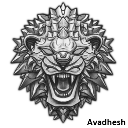

In [29]:
watermark,watermark_array=image_upload(watermark_img_path,128,"watermark")

In [30]:
ori_image,ori_array=image_upload(orignal_img_path,1024,"image")

Output hidden; open in https://colab.research.google.com to view.

In [31]:
watermarked=add_watermark(watermark_array,ori_array,9639)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
PSNR(ori_image,watermarked)

51.92382633527443

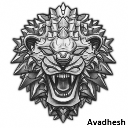

In [33]:
water_recover=recover_watermark(watermarked,128,9639)

In [ ]:
Quality(watermark,water_recover)

MSE:  8.553891706121736e-24
PSNR:  278.8091661316216
NC:  1.0000000000000793


In [1]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.01
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        cv2_imshow(noisy)
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1000
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        cv2_imshow(out)
        return out
    elif noise_typ == "crop_black":
        noisy=watermarked
        noisy[0:256,0:256,0]=np.zeros([256,256])
        noisy[0:256,0:256,1]=np.zeros([256,256])
        noisy[0:256,0:256,2]=np.zeros([256,256])
        cv2_imshow(noisy)
        return noisy
    elif noise_typ == "crop_white":
        noisy=watermarked
        noisy[0:256,0:256,0]=np.full([256,256],255)
        noisy[0:256,0:256,1]=np.full([256,256],255)
        noisy[0:256,0:256,2]=np.full([256,256],255)
        cv2_imshow(noisy)
        return noisy

In [2]:
noise_img=noisy("s&p",watermarked)
water_recov=recover_watermark(noise_img,128,9639)
Quality(watermark,water_recov)

NameError: ignored

In [ ]:
noise_img=noisy("gauss",watermarked)
water_recov=recover_watermark(noise_img,128,9639)
Quality(watermark,water_recov)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
noise_img=noisy("crop_black",watermarked)
water_recov=recover_watermark(noise_img,128,9639)
Quality(watermark,water_recov)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
noise_img=noisy("crop_white",watermarked)
water_recov=recover_watermark(noise_img,128,9639)
Quality(watermark,water_recov)

Output hidden; open in https://colab.research.google.com to view.